In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from bayes_traj.pyro_helper import *

torch.set_default_dtype(torch.double)

# Read toy data and plot

In [2]:
df = pd.read_csv('2d_gaussian_3_visits_std-0.05.csv')
preds = ['intercept', 'age']
targets = ['y1']

Color-code data based on ground-truth trajectory assignment ('traj_gt')

Text(0, 0.5, 'y1')

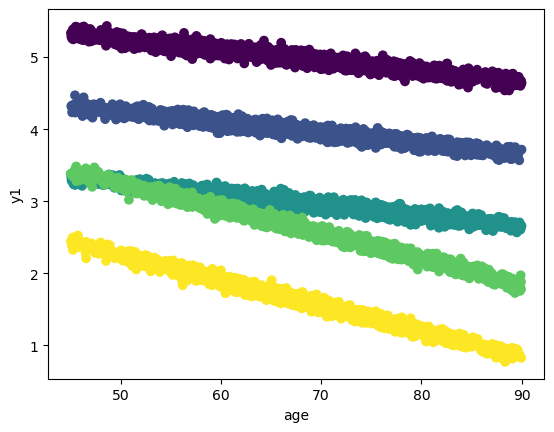

In [3]:
plt.scatter(df['age'], df['y1'], c=df['traj_gt'])
plt.xlabel('age')
plt.ylabel('y1')

# Fit to data

In [59]:
!bayes_traj_main --in_csv 2d_gaussian_3_visits_std-0.05.csv --targets y1 --groupby id --prior 2d_gaussians_3_visits_std-0.05_prior.p --verbose --iters 20 --repeats 1 --use_pyro -k 5 --out_model foo_pyro.pt

Reading prior...
Reading data...
Fitting...
step    0 loss = 44437524.486
Saving model...
Traceback (most recent call last):
  File "/opt/anaconda3/envs/pyro_env/bin/bayes_traj_main", line 33, in <module>
    sys.exit(load_entry_point('bayes-traj', 'console_scripts', 'bayes_traj_main')())
  File "/Users/jr555/Downloads/bayes_traj/bayes_traj/bayes_traj_main.py", line 274, in main
    pickle.dump({'MultDPRegression': mm}, open(op.out_model, 'wb'))
UnboundLocalError: local variable 'mm' referenced before assignment


# Inspect fit

In [60]:
model = torch.load('foo_pyro.pt')

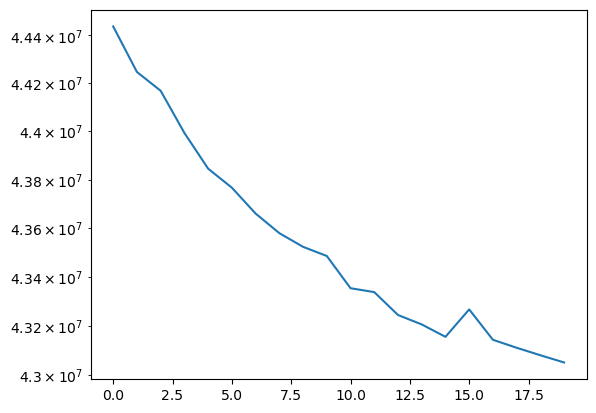

In [61]:
plt.plot(model.losses)
plt.yscale('log')

In [62]:
#X_re, X_mask, Y_re, Y_mask = get_restructured_data(df, preds, targets, 'id')
#print(X_re.shape)
#print(Y_re.shape)
#print(Y_mask.shape)

In [63]:
probs = model.classify(X_re, Y_real=Y_re, Y_real_mask=Y_mask)

In [64]:
print(probs)

tensor([[0.5600, 0.0400, 0.0200, 0.1200, 0.2600],
        [0.1500, 0.0000, 0.0100, 0.8100, 0.0300],
        [0.2800, 0.0000, 0.0300, 0.6200, 0.0700],
        ...,
        [0.0600, 0.4500, 0.3500, 0.0000, 0.1400],
        [0.0300, 0.3500, 0.4900, 0.0000, 0.1300],
        [0.0100, 0.3900, 0.5100, 0.0000, 0.0900]])


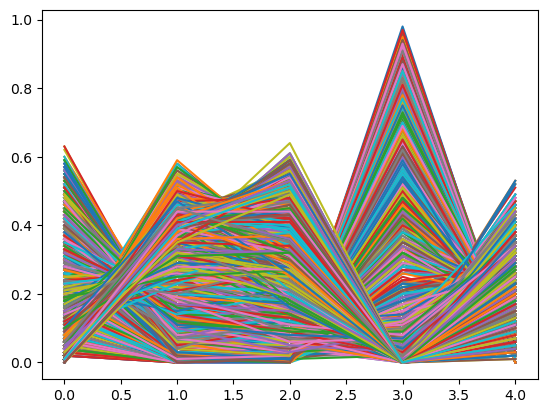

In [65]:
plt.plot(probs.T);

Overlap trajectories with data to inspect fit:

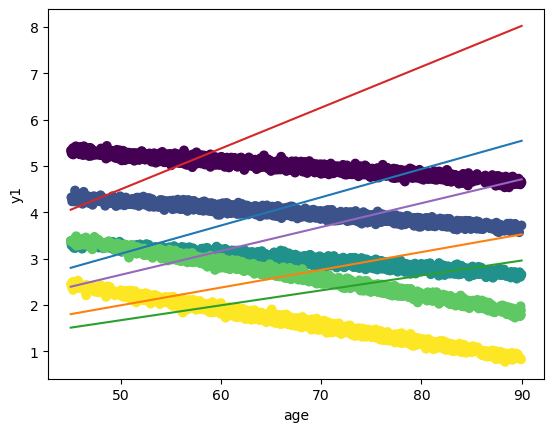

In [66]:
plt.close('all')

plt.scatter(df['age'], df['y1'], c=df['traj_gt'])
plt.xlabel('age')
plt.ylabel('y1')

K = 5
X = torch.ones([100, 2])
X[:, 1] = torch.linspace(45, 90, 100)
for kk in range(K):
    w = model.params['params']['AutoNormal.locs.W_'][kk, :, :]
    y1_tmp = np.dot(X.numpy(), w.detach().numpy().T)[:, 0]
    plt.plot(X[:, 1], y1_tmp)
plt.show()